In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

from IPython.display import display
from matplotlib.colors import Normalize
from sklearn import svm
from sklearn.base import clone 
from sklearn.datasets import make_blobs, make_classification
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc,roc_auc_score
from sklearn.metrics import classification_report, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

The dataset has been downloaded from Kaggle.
It is designed for the classification of heart attacks, a critical medical condition.
It is used for analytical and machine learning tasks related to predicting the likelihood 
of a heart attack based on various medical attributes

In [2]:
data = pd.read_csv('./heart.csv')

data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


The dataset includes several features (attributes) that provide information about patients and their health conditions. 
These features can be used to predict the likelihood of a heart attack. Some of the key features include:
 - age: The age of the patient.
 - sex: The gender of the patient (0 = female, 1 = male).
 - cp: Chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic).
 - trtbps: Resting blood pressure (in mm Hg).
 - chol: Serum cholesterol level (in mg/dl).
 - fbs: Fasting blood sugar (> 120 mg/dl) (1 = true, 0 = false).
 - restecg: Resting electrocardiographic results (0 = normal, 1 = having ST-T wave abnormality, 2 = probable or definite left ventricular hypertrophy).
 - thalachh: Maximum heart rate achieved.
 - exng: Exercise-induced angina (1 = yes, 0 = no).
 - oldpeak: ST depression induced by exercise relative to rest.
 - slp: Slope of the peak exercise ST segment.
 - caa: Number of major vessels colored by fluoroscopy.
 - thal: Thalassemia (a type of blood disorder) results (3 = normal, 6 = fixed defect, 7 = reversible defect).
 - Target Variable: output

# data cleansing

The data set being from Kaggle, we expect it to be pretty well curated, but soem basic checks should not hurt

### Identify missing data point

In [3]:
# get the number of missing data points per column
missing_values_count = data.isnull().sum()
print(missing_values_count)

# how many total missing values do we have?
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(str(percent_missing)+'%')

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64
0.0%


In [4]:
data.shape

(303, 14)

In [5]:
data.duplicated().sum()

1

In [6]:
data[data.duplicated()]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [7]:
data.drop_duplicates(inplace=True)

In [8]:
data.dropna(inplace=True)

In [9]:
data.shape

(302, 14)

After this short cleansing we note that no data was missing or 'N/A'and only 1 row was a duplicate 
therefore the data set is made of 302 rows and 14 columns

### Data discovery

Let's give a look at the data to better understand it 

In [10]:
data.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trtbps    302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalachh  302 non-null    int64  
 8   exng      302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slp       302 non-null    int64  
 11  caa       302 non-null    int64  
 12  thall     302 non-null    int64  
 13  output    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


So the whole dataset is made of integers or float data, no string or factor, eventhough we expect some of the data to be binary like 'Sex'. Let's actually, discover what sort of values we have.

In [12]:
unique_value_counts = {}
for column in data.select_dtypes(include=np.number):    
    unique_values = data[column].nunique()
    unique_value_counts[column] = unique_values
print(unique_value_counts)

{'age': 41, 'sex': 2, 'cp': 4, 'trtbps': 49, 'chol': 152, 'fbs': 2, 'restecg': 3, 'thalachh': 91, 'exng': 2, 'oldpeak': 40, 'slp': 3, 'caa': 5, 'thall': 4, 'output': 2}


Visualising the distribution of each variable makes its understanding easier

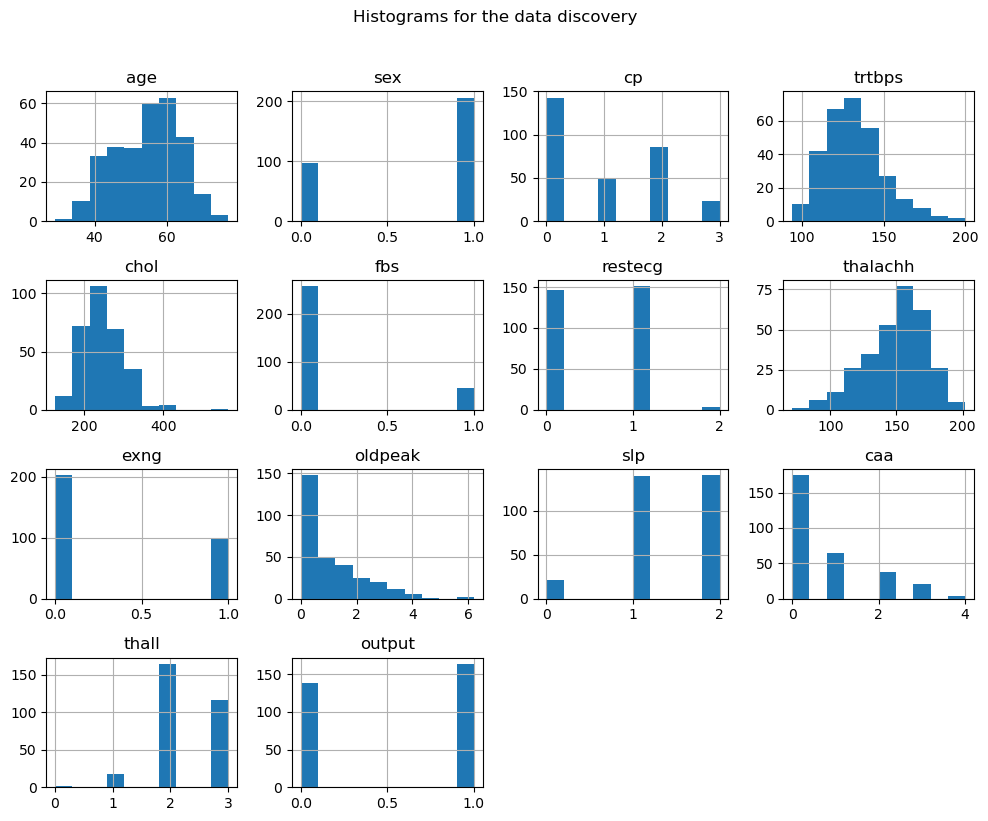

In [13]:
data.hist(figsize=(10, 8), bins=10)
plt.suptitle('Histograms for the data discovery', y=1.02)
plt.tight_layout()

Output is our target, our 'y' and is binary, leading to the conclusion of a classification approach.
So we indeed have binary data: Sex, fbs, exng
other fields may have more than 1 values not necessarily being continuous data: cp, restcg, slp, caa, thall

**We will have to bear in mind that Sex, fbs and exng appear to be highly imbalanced which might impact our models accuracy.** 

let's move on to further investigations:
Eventhough most fields are not continuous, doing a correlation matrix might help understand the relation among variables.

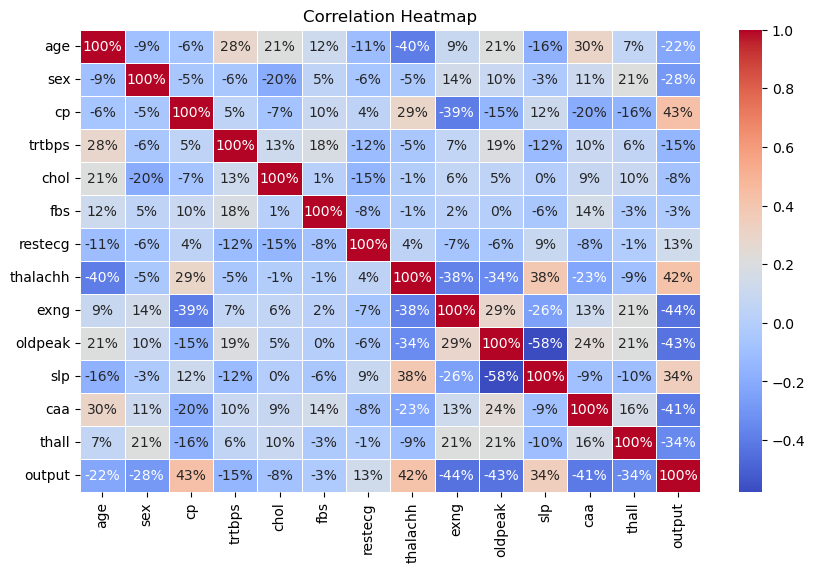

In [14]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.0%')
plt.title('Correlation Heatmap')
plt.show()

the strongest positive correlation is between cp and output with 43%
Most correlation are negative with the highest being between oldpeak and slp with -58% 
considering the relatively low correlation (no multicollinearity) we will consider all variables in our coming analyses

Let's now investigate dimensions distribution per sex 

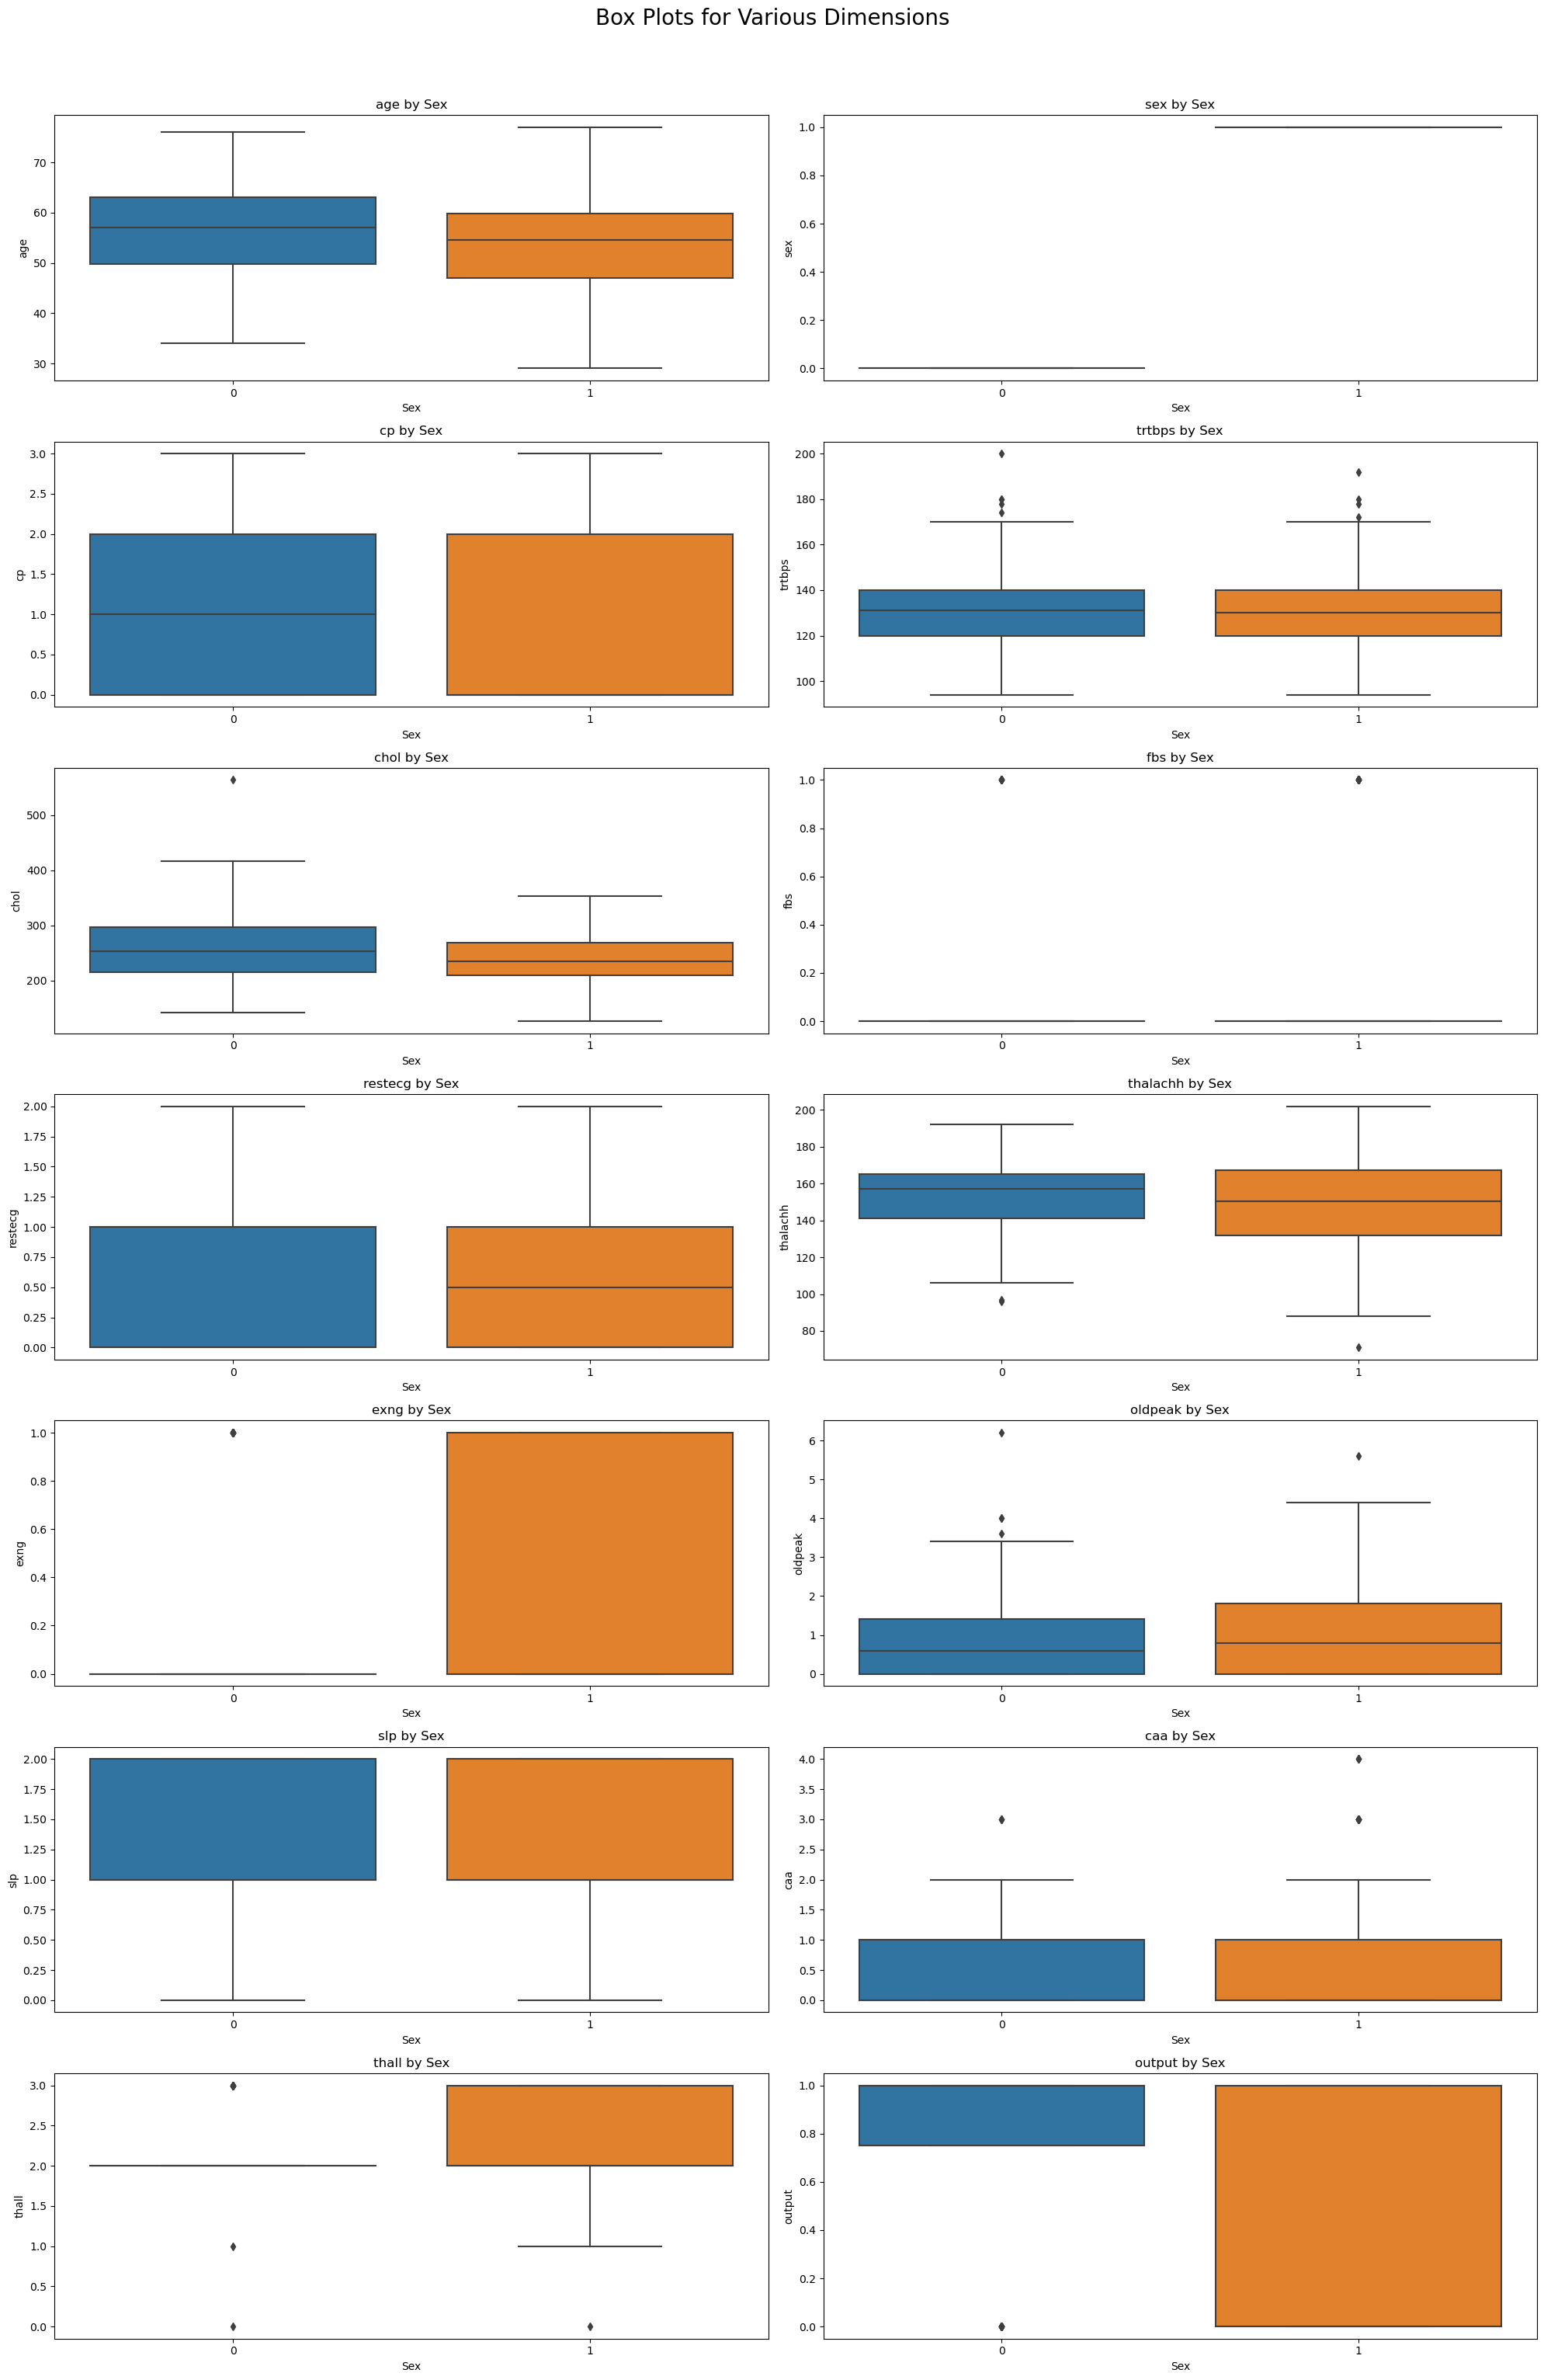

In [15]:
# Get the number of dimensions in your dataset
num_dimensions = len(data.columns)

# Calculate the number of rows and columns for subplots
num_rows = (num_dimensions // 2) + (num_dimensions % 2)
num_cols = 2

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 30))
fig.suptitle('Box Plots for Various Dimensions', y=1.02, size = 20)

# Flatten the axes array to simplify indexing
axes = axes.flatten()

for i, dimension in enumerate(data.columns):
    sns.boxplot(ax=axes[i], x='sex', y=dimension, data=data)
    axes[i].set_xlabel('Sex')
    axes[i].set_ylabel(dimension)
    axes[i].set_title(f'{dimension} by Sex')

# Adjust layout
plt.tight_layout()
plt.show()

 - age: Women seems to be a little older than Men
 - cp: although overall shape is similar, we see the median for Women but not for Men, implying that thewhol distribution 
 - trtbps: no visible difference
 - chol: no major difference although Women sem to have a little broader distribution and slightly higher median. 
 - exgn: no data for Women
 - caa: no visible difference
 - thall: apart from 3 outliers, all Women appear to have a thall at 2
 - Output: binary data so spread is meaning less

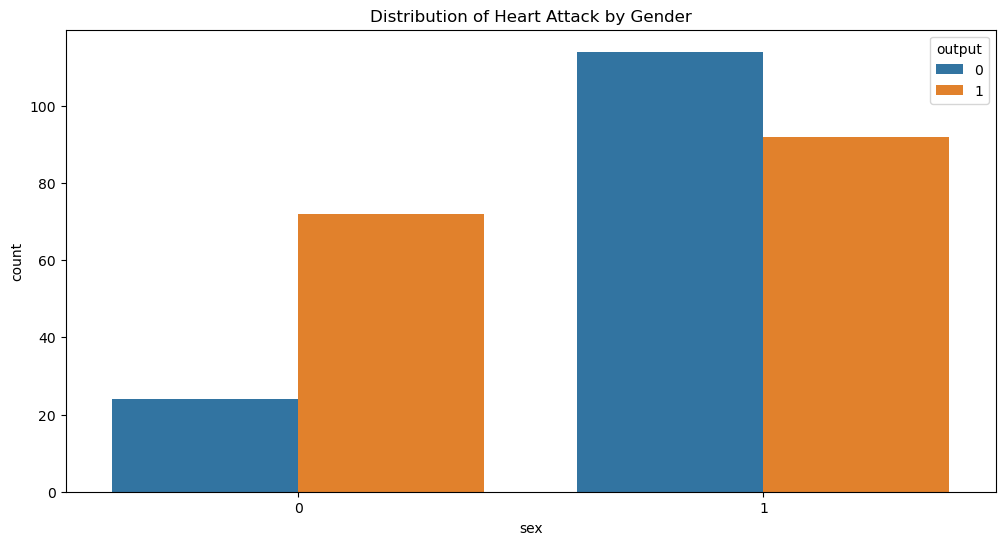

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(x='sex', data=data, hue='output')
plt.title('Distribution of Heart Attack by Gender')
plt.show()

Data set is having more Men(1) than Women(0) but the proportion of Heart Attack (output = 1) is much higher for Women than for Men. We may expect this imbalance to impact our models accuracy.

## Data scaling

We scale the dataset to render comparison meaningful and allow models to run.

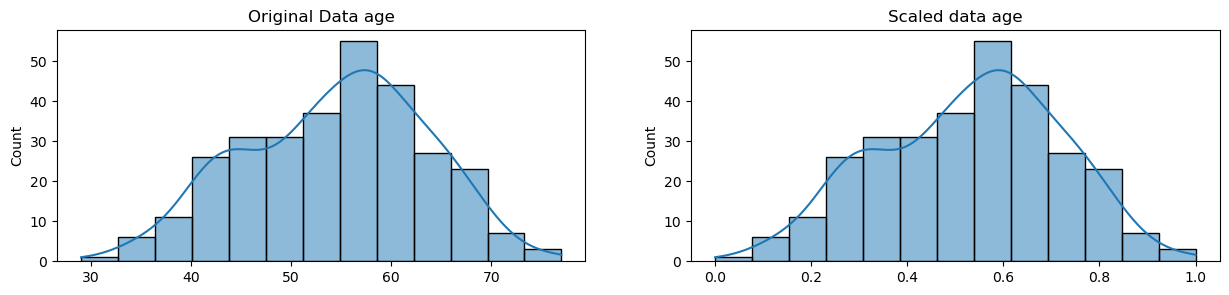

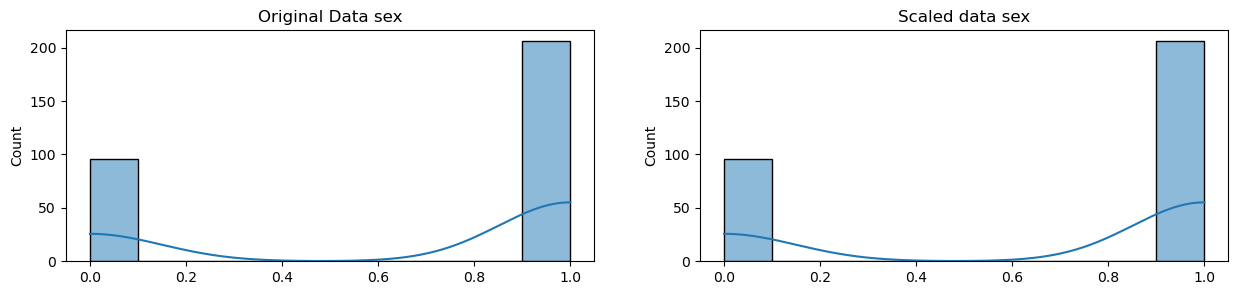

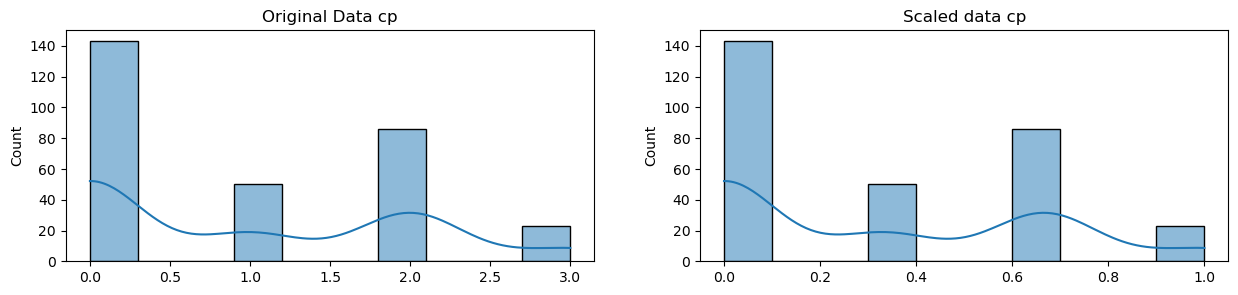

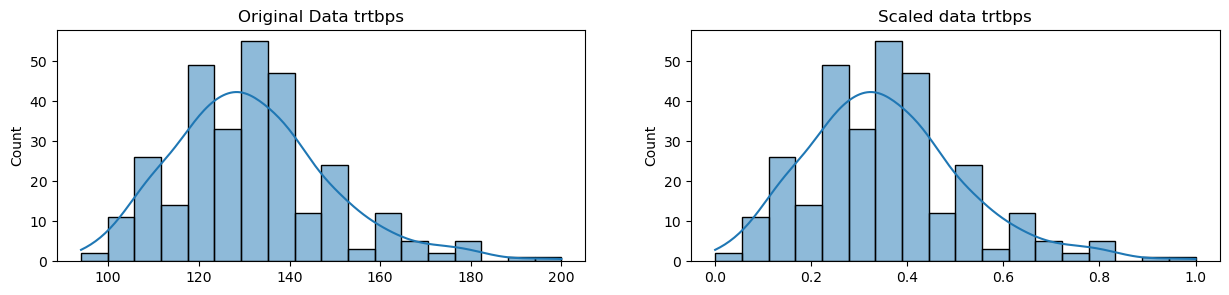

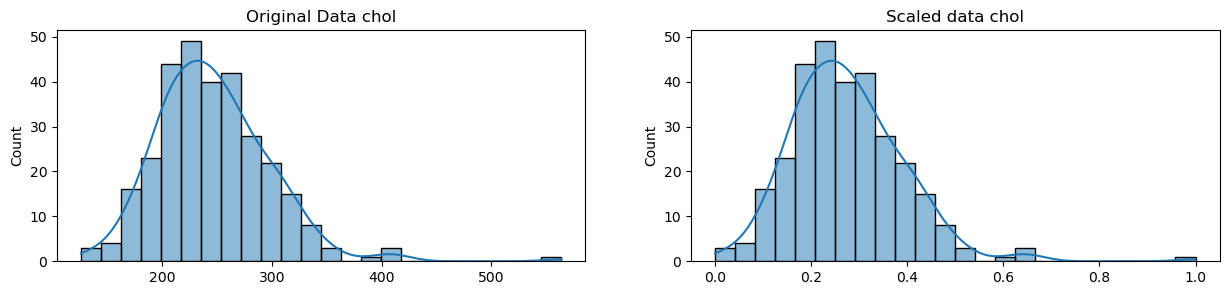

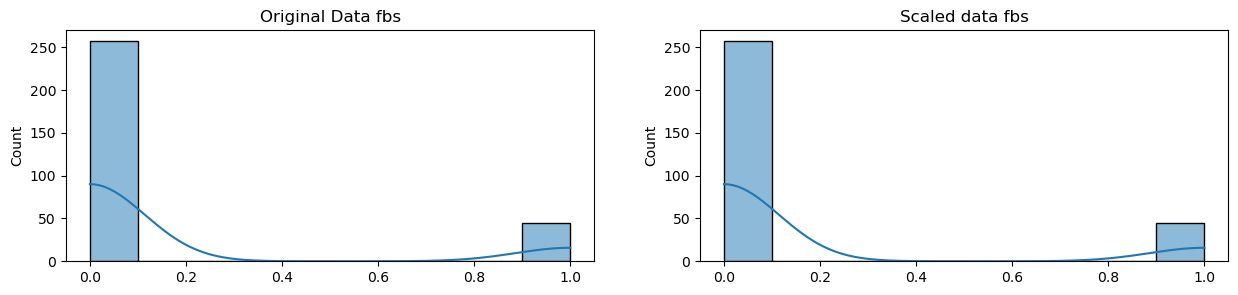

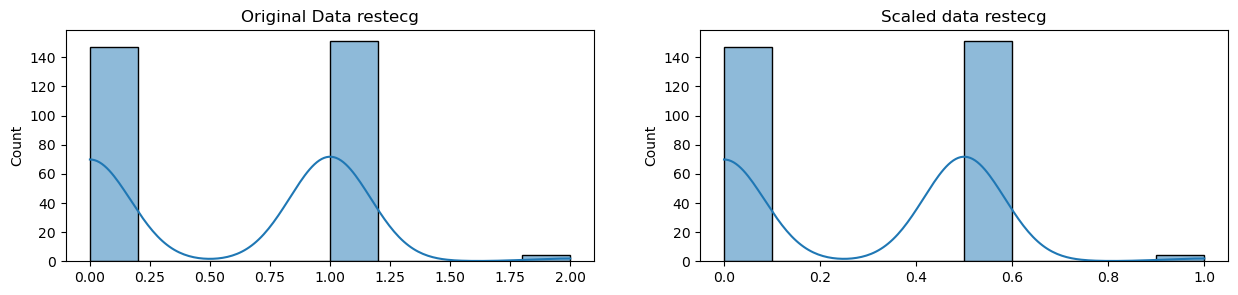

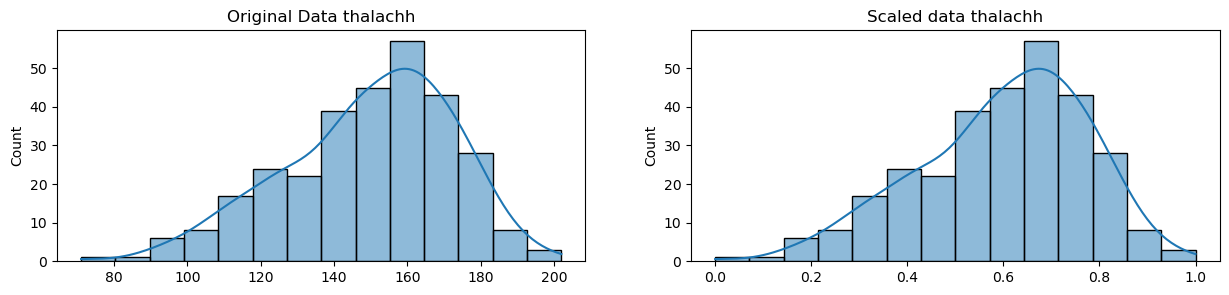

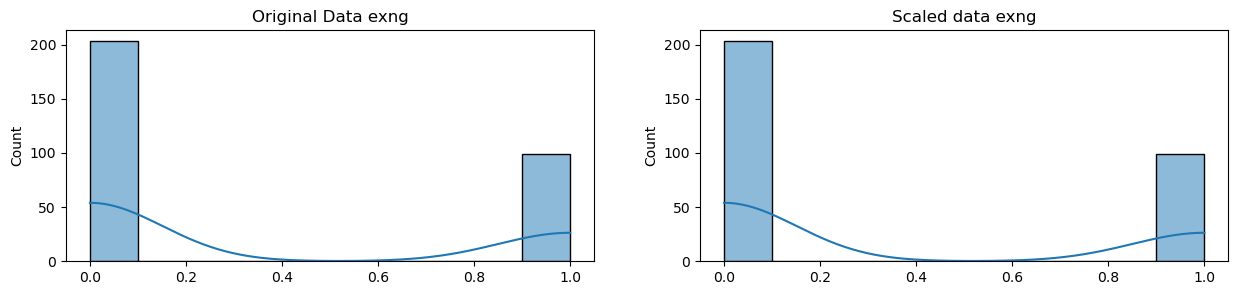

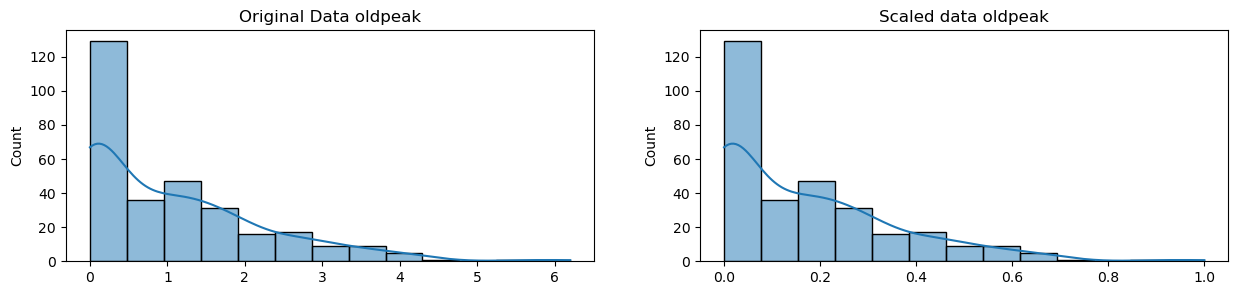

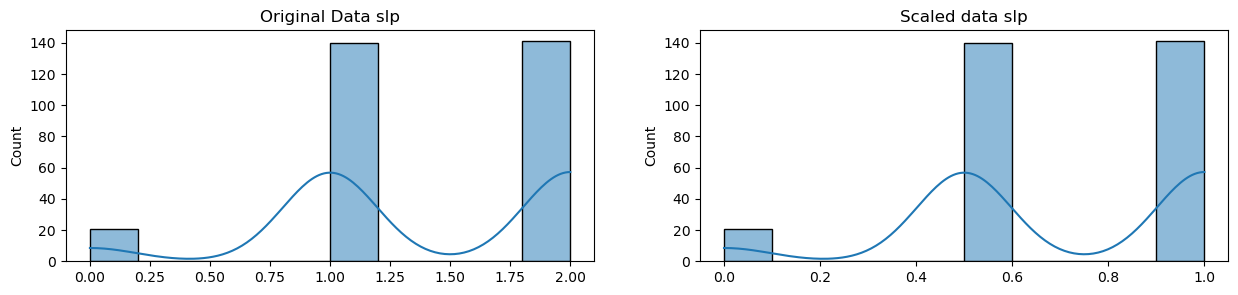

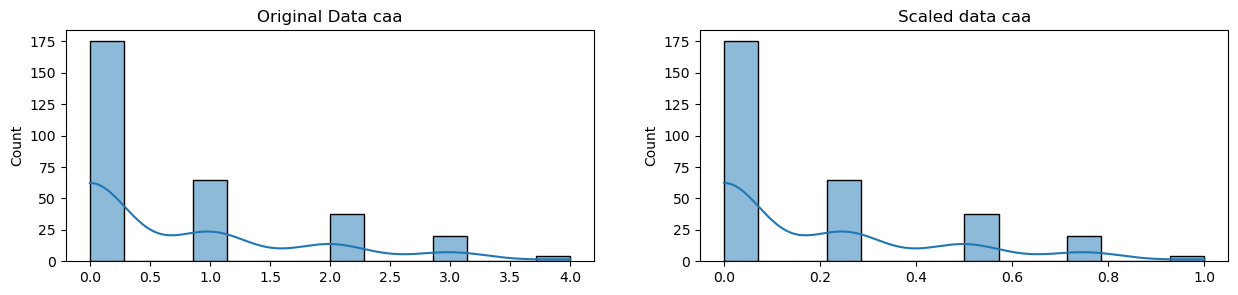

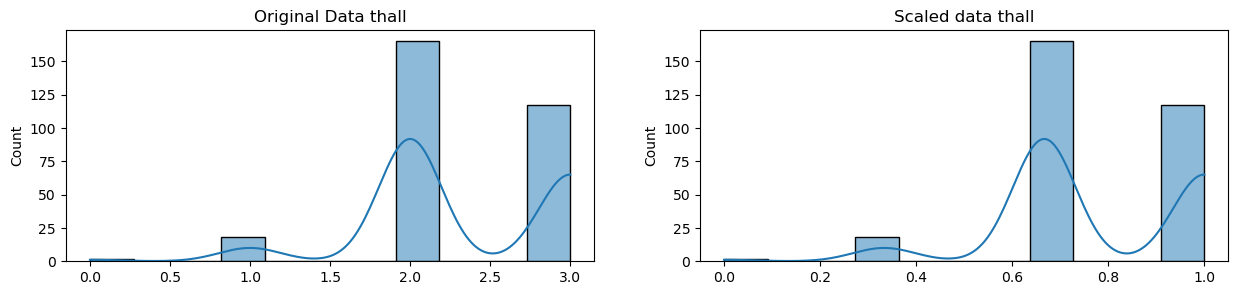

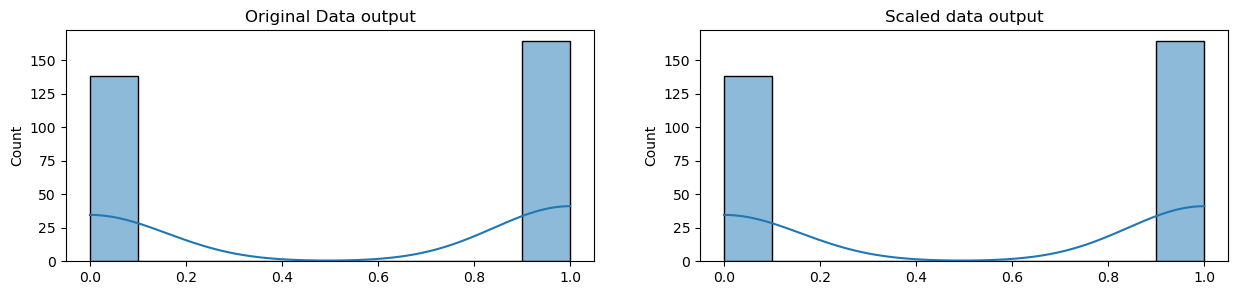

In [17]:
# Extract all columns name as a list
column_names = data.columns.tolist()
# Create a new DataFrame for scaled data
scaled_df = pd.DataFrame()

for dim in column_names:
    original_data = data[[dim]]
    # Using sklearn's MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on the data and transform it
    scaled_data = scaler.fit_transform(original_data)
    
    # Add the scaled data to the new DataFrame
    scaled_df[dim] = scaled_data.flatten()

    # Display the scaled data
    # plot both together to compare
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
    ax[0].set_title("Original Data "+dim)
    sns.histplot(scaled_data, ax=ax[1], kde=True, legend=False)
    ax[1].set_title("Scaled data "+dim)
    plt.show()

Let's do a pair plot to further visualise relationship, eventhough the former heatMap did not reveal strong relationship amoung dimensions: no visible multicollinearity)

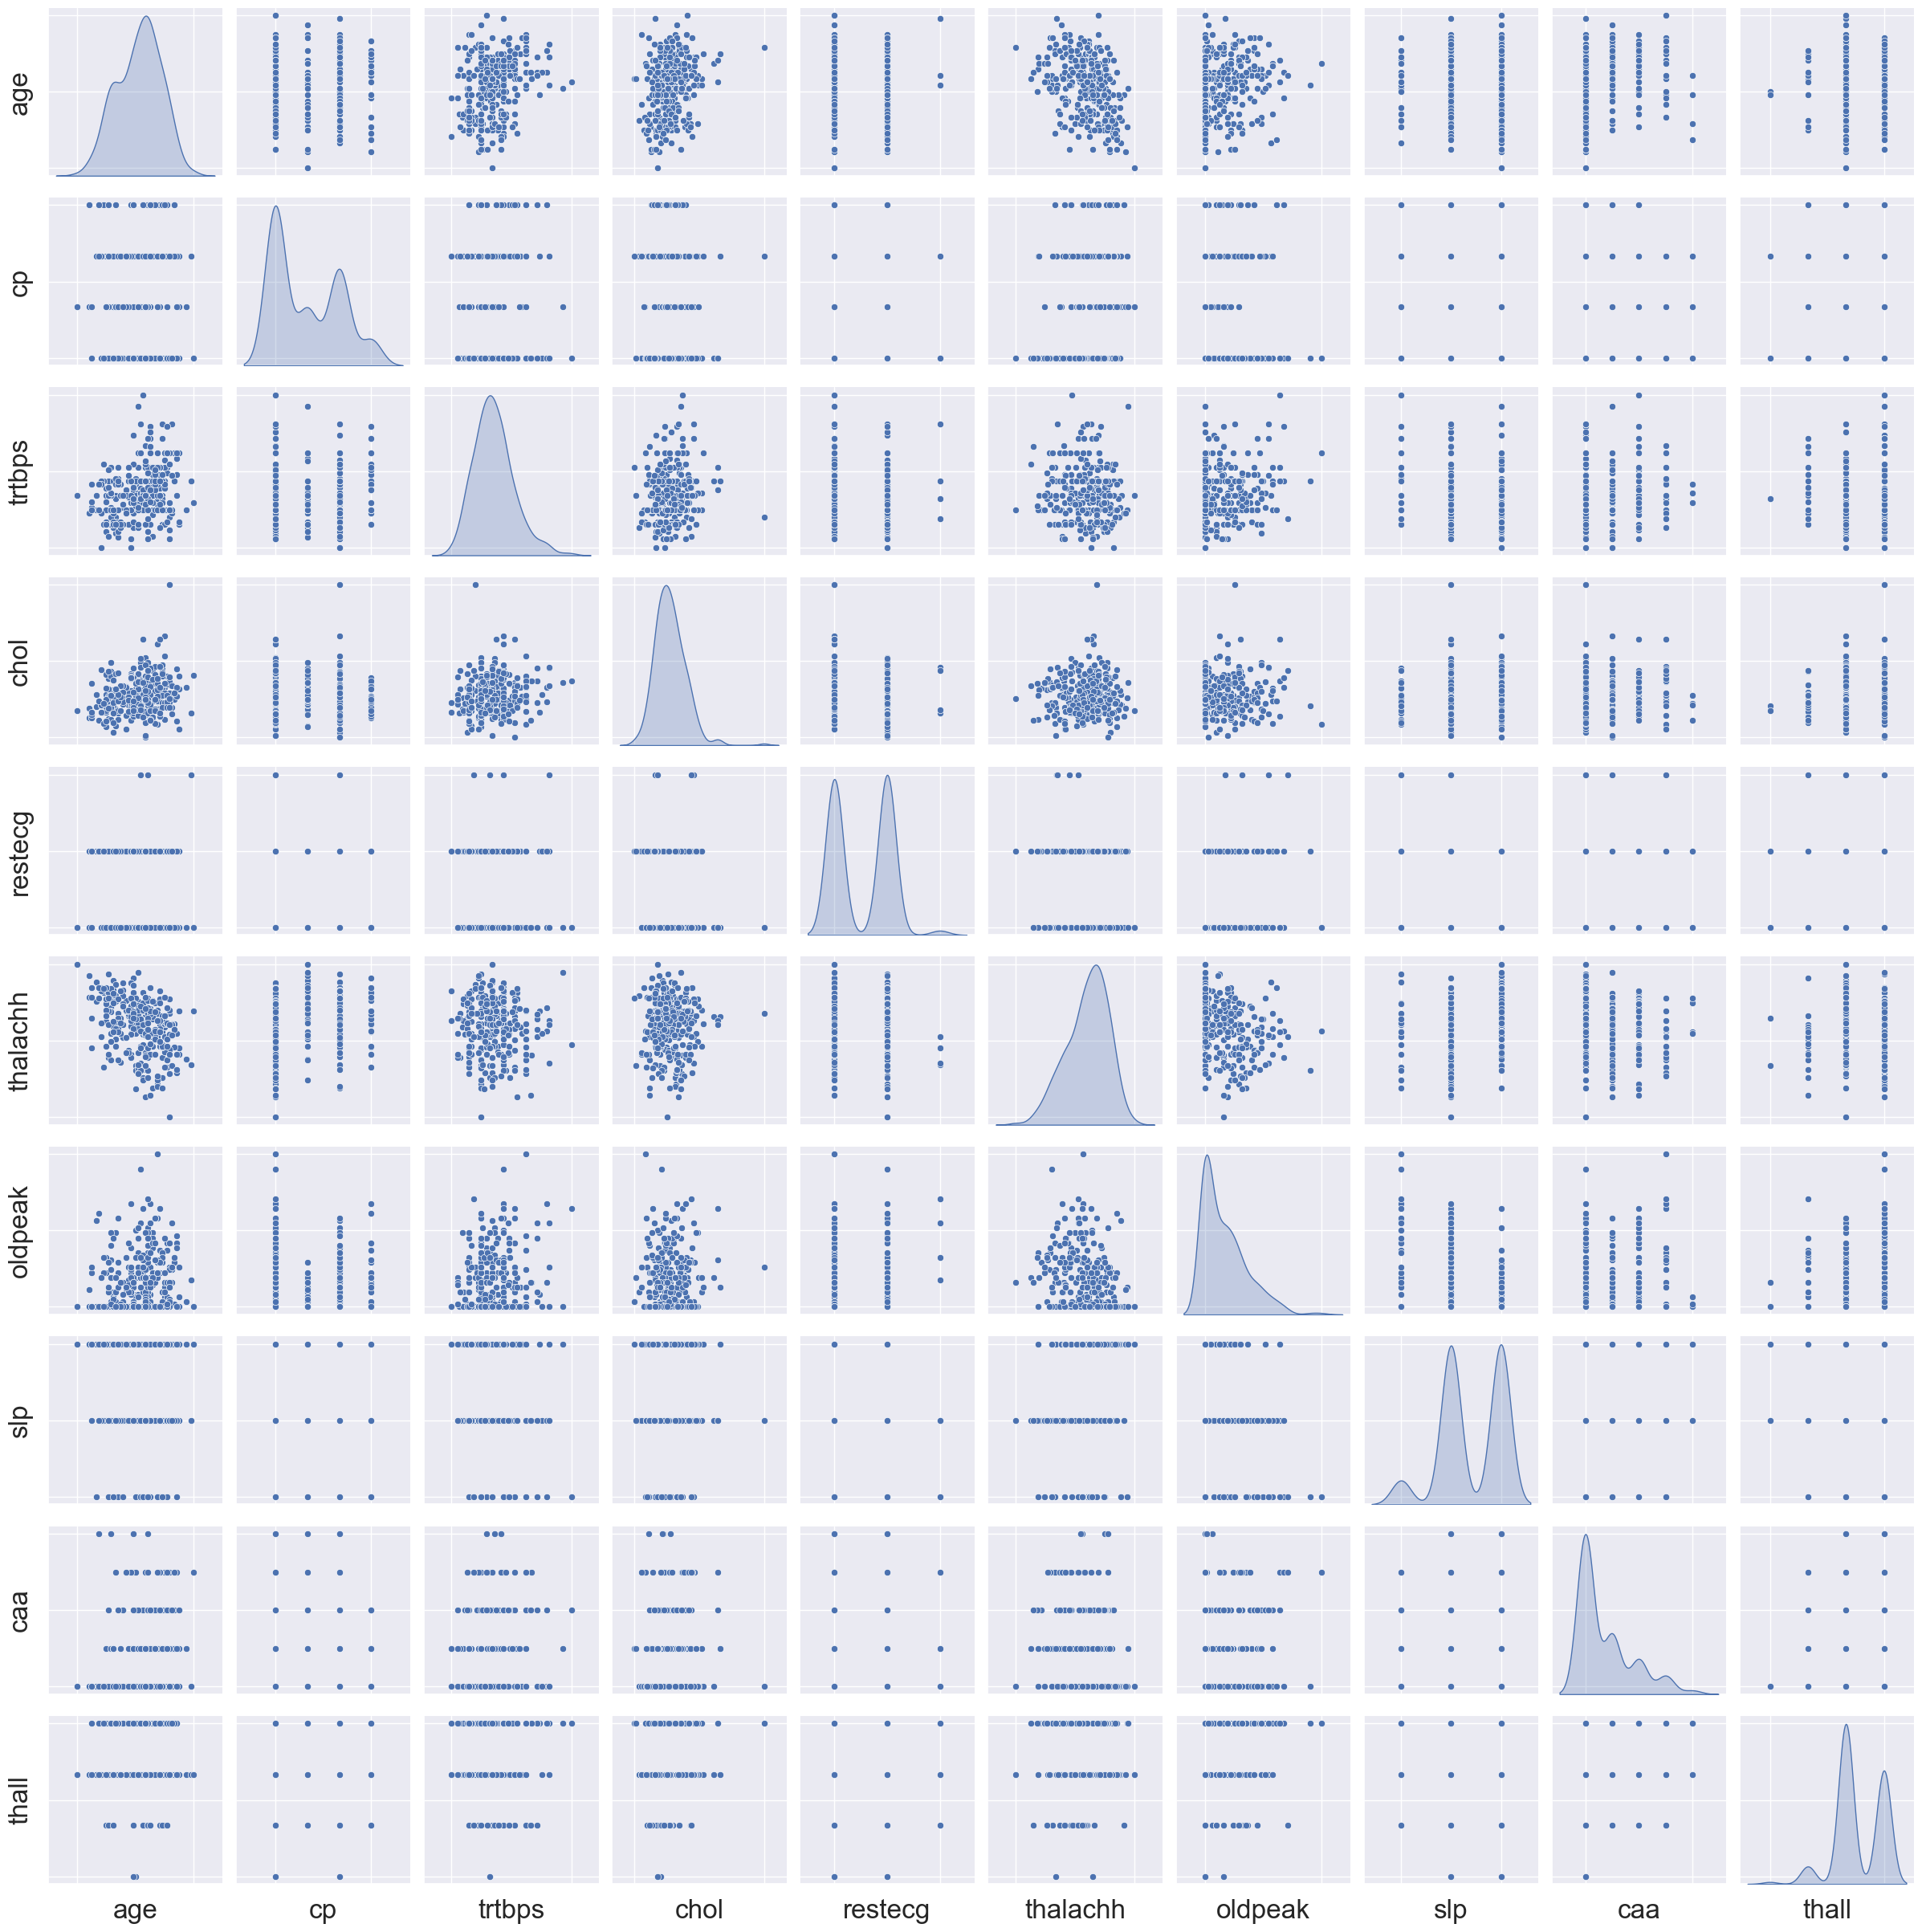

In [18]:
binary_dim = ['sex','fbs','exng','output']
continuous_data = scaled_df.drop(binary_dim, axis = 1)

sns.set(color_codes=True,font_scale= 2)
sns.pairplot(continuous_data, diag_kind="kde").set(xticklabels=[],yticklabels=[])
plt.show()

Doing the same pairplot but visualizing for Heart Attack vs Non-Heart Attack and filtering only relevant dimensions to see if any is standing out. 

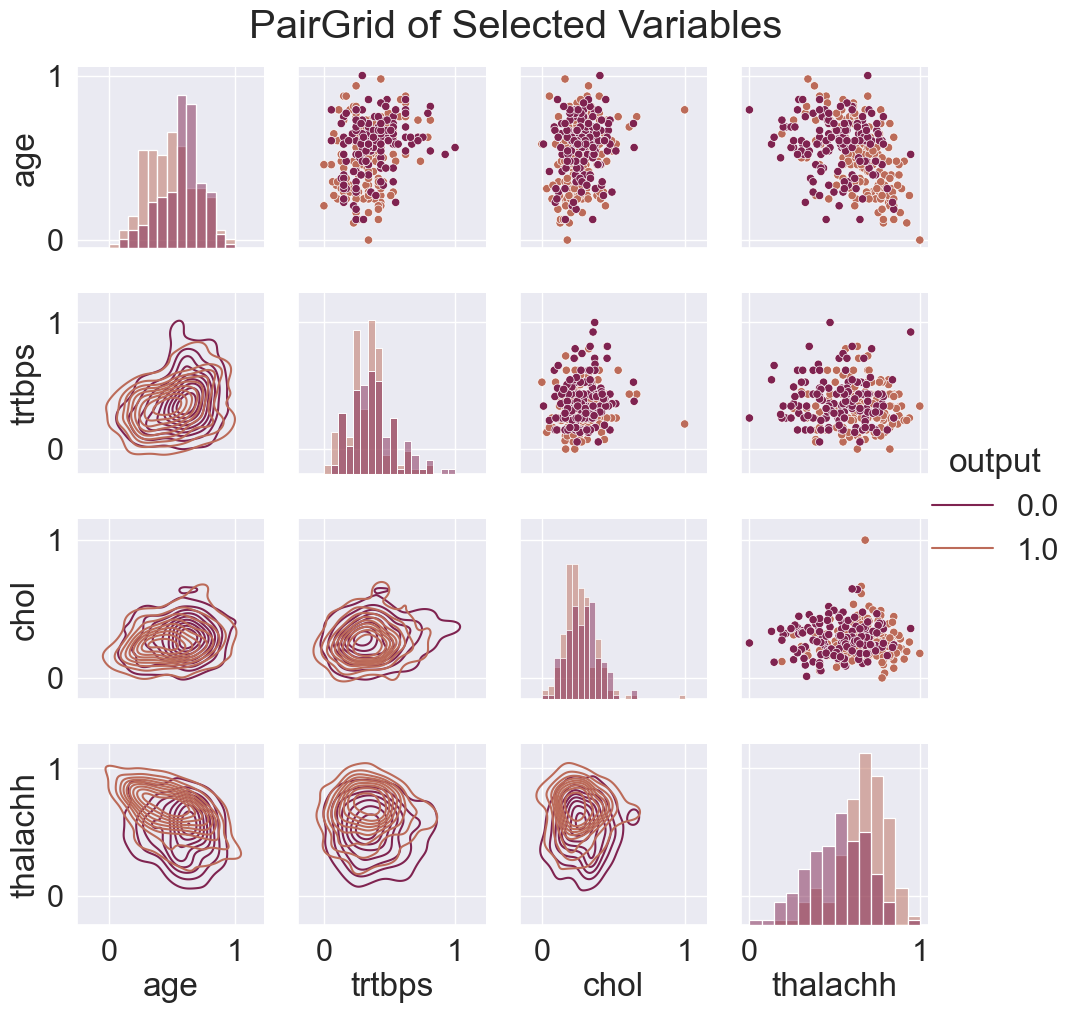

In [19]:
kept_dim = ['age', 'trtbps', 'chol', 'thalachh', 'output']
secondary_data = scaled_df[kept_dim]

# Set the color palette
sns.set_palette('twilight_shifted_r')

# Create PairGrid
pp = sns.PairGrid(secondary_data, hue='output')

# Map the plots
pp.map_upper(sns.scatterplot)
pp.map_diag(sns.histplot, kde_kws={'color': 'k'})
pp.map_lower(sns.kdeplot, cmap='Blues_d')

# Add legend
pp.add_legend()

# Set figure title
pp.fig.suptitle('PairGrid of Selected Variables', y=1.02)

# Show the plot
plt.show()


Pair-wise does not allow to clearly differentiate a unique cause of the output. 
Heart Attack seems to happen more frequently in the high end of Thalachh, and also in the early ages (in this dataset)

## Data Analysis

### define Train and Test data sets

In [20]:
# Assuming 'scaled_df' contains your features and target variable
X = scaled_df.drop('output', axis=1)  # Features (excluding the target variable)
y = scaled_df['output']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print (len(X_train))
print (len(X_test))

241
61


Eventhough this is clearly a classification question, we will start by conducting a linear regression for 2 reasons:
 - as an exercise to practice our new knowledge
 - as a benchmark to see up to which MSE we can get using a linear regression. Knowing that we may not diretcly compare MSE with Accuracy

Lets get the top 3 predictors based on R Squared

In [21]:
dim_list = X_train.columns[:]
r_sqr= {}
for elt in dim_list:
    myformula = 'output ~'+elt
    r_sqr[elt] = smf.ols(formula= myformula, data=pd.concat([X_train, y_train], axis=1)).fit().rsquared_adj

# Print all R_squared values per dimensions as percentage
formatted_r_sqr = {key: f'{value:.2f}' for key, value in r_sqr.items()}
# Display the modified dictionary
print(formatted_r_sqr)

#update following value according to the result
sorted_dim_adj_R2 =  sorted(r_sqr, key=r_sqr.get, reverse=True)
print (sorted_dim_adj_R2)

# display top_three
print("\n"'_________________'"\n")
print('top 3 predictors')
top_three = sorted_dim_adj_R2[:3]
print(top_three)

{'age': '0.04', 'sex': '0.08', 'cp': '0.15', 'trtbps': '0.02', 'chol': '-0.00', 'fbs': '-0.00', 'restecg': '0.01', 'thalachh': '0.16', 'exng': '0.17', 'oldpeak': '0.17', 'slp': '0.12', 'caa': '0.15', 'thall': '0.14'}
['oldpeak', 'exng', 'thalachh', 'caa', 'cp', 'thall', 'slp', 'sex', 'age', 'trtbps', 'restecg', 'chol', 'fbs']

_________________

top 3 predictors
['oldpeak', 'exng', 'thalachh']


### Linear Regression
Considering all the predictors, let see the R squared evolution while adding them to the model.

{'oldpeak': '17.61%', 'exng': '27.44%', 'thalachh': '31.09%', 'caa': '38.20%', 'cp': '41.34%', 'thall': '45.42%', 'slp': '46.30%', 'sex': '49.38%', 'age': '49.46%', 'trtbps': '50.45%', 'restecg': '50.82%', 'chol': '50.94%', 'fbs': '51.20%'}


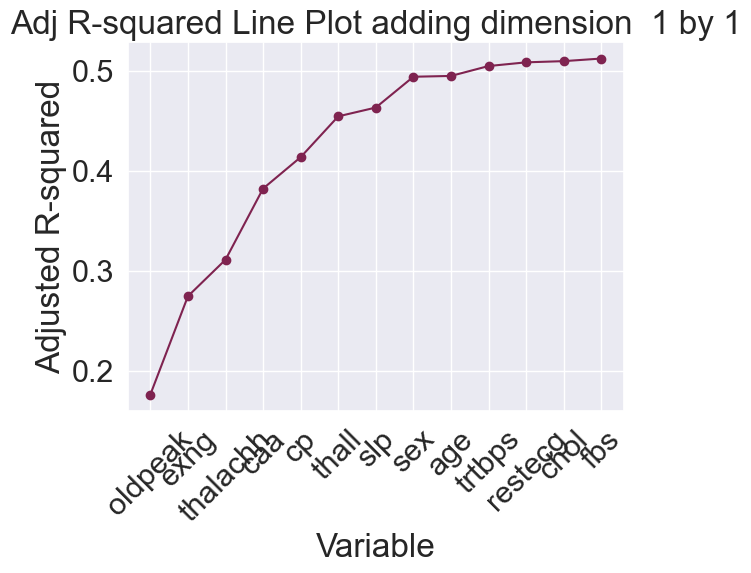

In [22]:
# lets compute the multi-regression and see which one is best
R_sq = {}
multi_reg_dim = []
my_new_formula = []
dim = sorted_dim_adj_R2

def incr_dim_formula(dim):
    form = ''
    lgth = len(dim)
    for elt in range (0,lgth):
        form += dim[elt]+' +'
    form = form[:-1] # to exclude the '+ at the end of the string'
    return form

for n in dim:
    multi_reg_dim.append(n)
    multi_reg_formula = incr_dim_formula(multi_reg_dim)
    calc_formula = 'output~'+ multi_reg_formula
    R_sq[n] = smf.ols(formula = calc_formula, data=pd.concat([X_train, y_train], axis=1)).fit().rsquared

for key, value in R_sq.items():
    R_sq[key] = f'{value:.2%}'
print (R_sq)

# Extract keys and values from the sorted dictionary
keys = list(R_sq.keys())
values = list(R_sq.values())

# values being a list of string, I need to cnvert into float to display on chart
float_values = [float(value.strip('%')) / 100 for value in values]

# Plot a line based on the sorted dictionary
plt.plot(keys, float_values, marker='o', linestyle='-')
plt.xlabel('Variable')
plt.ylabel('Adjusted R-squared')
plt.title('Adj R-squared Line Plot adding dimension  1 by 1')
plt.xticks(rotation=45)
plt.show()

Adding all featurs in the model, 1 by 1 t osee the Rsquared evolution we see that the R squared caps at 51%, which is barely better than random selection. 

### Polynomial
Let's explore the impact of going polynomial on R squared

In [23]:
# explore polynomial regression based o the best predictor
polynomial_degree = 3
R_sq = {}
my_formula = []

def formula(n,dim):
    form = ''
    for elt in range (1,n+1):
        form += 'np.power('+dim+','+ str(elt)+') +'
    form = form[:-1] # to exclude the '+ at the end of the string'
    return form

for dim in range (0, len(sorted_dim_adj_R2)-1):
    R_sq = {}
    my_formula = []
    print ('Dimension considered in polynomial: _____',sorted_dim_adj_R2[dim])
    for n in range(1,polynomial_degree+1):
        my_formula.append(formula(n, sorted_dim_adj_R2[dim]))
        calc_formula = 'output~'+ my_formula[n-1]
        R_sq[n] = smf.ols(formula = calc_formula, data=pd.concat([X_train, y_train], axis=1)).fit().rsquared
        formatted_r_sqr = {key: f'{value:.1%}' for key, value in R_sq.items()}
    print (formatted_r_sqr)


Dimension considered in polynomial: _____ oldpeak
{1: '17.6%', 2: '17.9%', 3: '18.4%'}
Dimension considered in polynomial: _____ exng
{1: '17.4%', 2: '17.4%', 3: '17.4%'}
Dimension considered in polynomial: _____ thalachh
{1: '16.4%', 2: '16.4%', 3: '16.7%'}
Dimension considered in polynomial: _____ caa
{1: '15.7%', 2: '23.2%', 3: '23.2%'}
Dimension considered in polynomial: _____ cp
{1: '15.0%', 2: '22.3%', 3: '23.0%'}
Dimension considered in polynomial: _____ thall
{1: '14.1%', 2: '24.6%', 3: '29.2%'}
Dimension considered in polynomial: _____ slp
{1: '12.0%', 2: '14.8%', 3: '14.8%'}
Dimension considered in polynomial: _____ sex
{1: '8.8%', 2: '8.8%', 3: '8.8%'}
Dimension considered in polynomial: _____ age
{1: '4.4%', 2: '5.1%', 3: '6.2%'}
Dimension considered in polynomial: _____ trtbps
{1: '2.4%', 2: '2.8%', 3: '3.1%'}
Dimension considered in polynomial: _____ restecg
{1: '1.8%', 2: '3.6%', 3: '3.6%'}
Dimension considered in polynomial: _____ chol
{1: '0.1%', 2: '0.8%', 3: '1.1%'}


polynomial does not appear to bring any value to this question. 
Thall is the dimension benefitting the most for going polynomial. 

### Logistic Regression
Output being binary, Logistic Regression is the natural model to start  with.
Let see if this does better than Linear regression, eventhough we are not measuring Rsquared or MSE anymore but Accuracy.
Let's also visualise the performance though the ROC curve.

Model Accuracy: 0.820
Model Precision: 0.84
Model Recall: 0.81


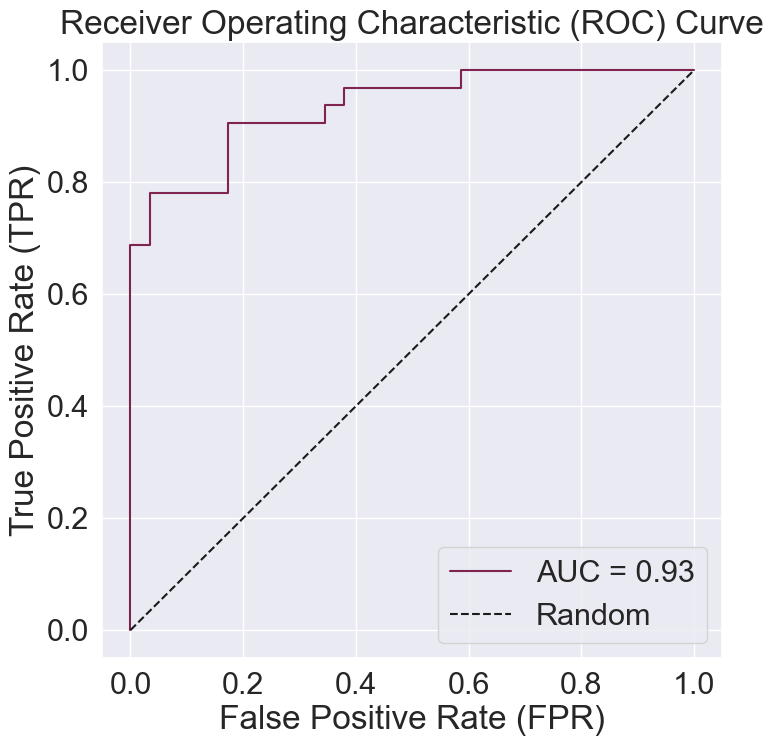

In [24]:
# LR model
LogReg = LogisticRegression(solver='liblinear').fit(X_train, y_train)

# Plot the ROC curve ( True positive rate v/s False positive rate) and indicate the AUC on the plot
y_pred_prob = LogReg.predict_proba(X_test)[:, 1]

# Compute the area under the curve (AUC)
auc_sc = roc_auc_score(y_test, y_pred_prob)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

y_pred = LogReg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Model Accuracy: %0.3f' % accuracy)
print('Model Precision: %0.2f' % precision)
print('Model Recall: %0.2f' % recall)


# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc_sc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()

- Model Accuracy: 0.820: of all predicted results 82% were correct 
- Model Precision: 0.84: 84% of what was predicted as positive was actualy the right output
- Model Recall: 0.81: 81% of positive output were predicted correctly
- AUC: 0.93
<br>
the Logistic regression appears to work pretty well on this dataset


### Decision Tree
Let's now investigate the performance of a decision tree

In [25]:
def build_dt(data_X, data_y, max_depth = None, max_leaf_nodes =None):
    # Initialize the DecisionTreeClassifier with specified parameters
    dt_classifier = DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, random_state=42)
    
    # Fit the classifier to the data
    dt_classifier.fit(data_X, data_y)
    
    return dt_classifier  

In [26]:
# Create a Decision Tree model with max_depth of 4
tree_model = build_dt(X_train, y_train, max_depth = 4, max_leaf_nodes =None)

# Make predictions on the test set
y_pred = tree_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Model Accuracy: %0.3f' % accuracy)
print('Model Precision: %0.2f' % precision)
print('Model Recall: %0.2f' % recall)
print(f"Tree Depth: {tree_model.tree_.max_depth}")

Model Accuracy: 0.803
Model Precision: 0.88
Model Recall: 0.72
Tree Depth: 4


Accuracy appears to be a little lower than for the Logistic regression, with 80.3% vs 82.0 %
but we wold like to optimize the parameter to ensure DT a underperforming.

let's optimize the parameters

### Pruning the Decision Tree

Number of nodes in the last tree is: 1 with ccp_alpha: 0.12167886012700058


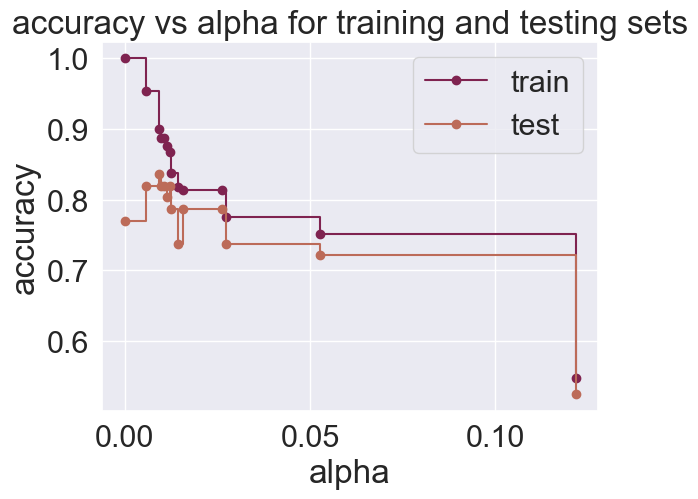

Optimal ccp_alpha: 0.009324202680296934
Max Depth: 6
Max Leaf Nodes: 15
Recall: 0.78125
Precision: 0.8928571428571429
Accuracy: 0.8360655737704918


In [27]:
clfs = [] 

# Get the ccp_alpha values
path = tree_model.cost_complexity_pruning_path(X_train, y_train) 
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Iterate over ccp_alpha values
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

# Generate train and test scores
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# your code here
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle="steps-post")
ax.legend()
plt.show() 

# Find the index of the maximum test score
optimal_alpha_index = np.argmax(test_scores)

# Get the corresponding optimal ccp_alpha value
optimal_alpha = ccp_alphas[optimal_alpha_index]

# Create the optimal Decision Tree with the optimal ccp_alpha
optimal_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_alpha)
optimal_clf.fit(X_train, y_train)

# Extract additional information
max_depth = optimal_clf.tree_.max_depth
# max_leaf_nodes = optimal_clf.tree_.max_leaf_nodes
max_leaf_nodes = np.sum(optimal_clf.tree_.children_left == optimal_clf.tree_.children_right)
y_pred = optimal_clf.predict(X_test)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the obtained information
print("Optimal ccp_alpha:", optimal_alpha)
print("Max Depth:", max_depth)
print("Max Leaf Nodes:", max_leaf_nodes)
print("Recall:", recall)
print("Precision:", precision)
print("Accuracy:", accuracy)

By optimizing the paramters of the DT, we gain 3.3 pts in accuracy from 80.3% to now 83.6%.
max depth has increased to 6 levels, which may indictae a risk of overfitting which we perceive on hte left hand side of the graph where there is a material difference between train and test results.

## AdaBoost
let's go to the next level by implementing AdaBoosts from sklearn and see if any difference stands out. 

Let's already optimize parameters by suggesting the number of estimators to consider and and various learning rates. We will also implement Cross Validation (5 folds) at the same time to ensure robust result.

In [28]:
# Create a base learner (in this case, a depth up to 3 decision tree, to ensure some DT diversification)
base_classifier = DecisionTreeClassifier(max_depth=3)  

# Create AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(base_classifier,  random_state=42)

# Define a parameter grid for cross-validation
n_estimators_list = list(range(1, 20, 2))
param_grid = {'n_estimators': n_estimators_list,'learning_rate': [0.01, 0.1, 0.5, 1.0] } 

# Create GridSearchCV object
grid_search = GridSearchCV(adaboost_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the classifier on the training data with cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters and the best classifier
best_params = grid_search.best_params_
best_adaboost_classifier = grid_search.best_estimator_

# Make predictions on the test set using the best classifier
y_pred = best_adaboost_classifier.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Best parameters: {best_params}")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Model Accuracy: %0.3f' % accuracy)
print('Model Precision: %0.2f' % precision)
print('Model Recall: %0.2f' % recall)
print(f"Tree Depth: {tree_model.tree_.max_depth}")


Best parameters: {'learning_rate': 0.01, 'n_estimators': 13}
Model Accuracy: 0.852
Model Precision: 0.87
Model Recall: 0.84
Tree Depth: 4


Accuracy is now reaching 85.2% with optimized adaBoost considering a small learning rate of 1%, 13 estimators and Tree depth at 4.

Now let's use te sklearn AdaBoostClassifier and test for various estimators

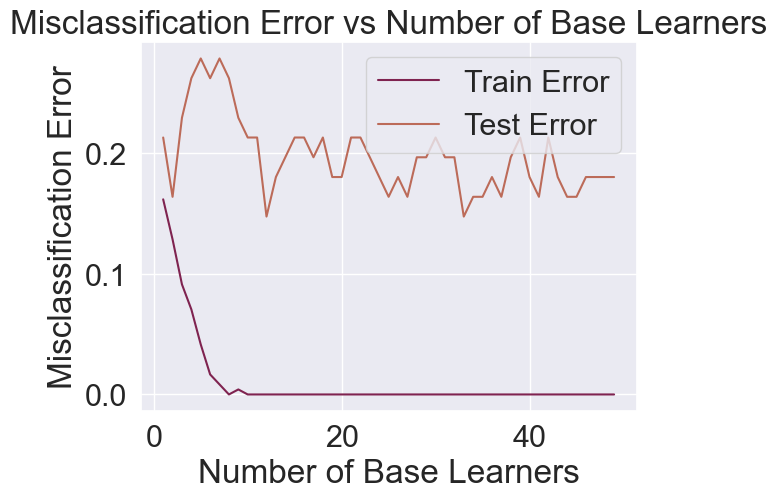

,Metric,Value
0,Optimal Number of Base Learners,12
1,Optimal Test Misclassification Error,14.75%
2,Optimal Accuracy,85.25%


Split,Test,Train
KPI,,
Precision,84.85%,100.00%
Recall,87.50%,100.00%


In [29]:
train_errors = []
test_errors = []
train_recall = []
test_recall = []
train_precision = []
test_precision = []

clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), random_state=42)

for i in range(1, 50):
    # Set the number of base learners for the current iteration
    clf.n_estimators = i
    
    # Train AdaBoost classifier
    clf.fit(X_train, y_train)
    
    # Predict on the training set
    train_predict = clf.predict(X_train)
    
    # Calculate misclassification error, recall, and precision on the training set
    train_error = np.mean(train_predict != y_train)
    train_recall.append(recall_score(y_train, train_predict))
    train_precision.append(precision_score(y_train, train_predict))
    train_errors.append(train_error)
    
    # Predict on the test set
    test_predict = clf.predict(X_test)
    
    # Calculate misclassification error, recall, and precision on the test set
    test_error = np.mean(test_predict != y_test)
    test_recall.append(recall_score(y_test, test_predict))
    test_precision.append(precision_score(y_test, test_predict))
    test_errors.append(test_error)

# Plot misclassification errors
plt.plot(range(1, 50), train_errors, label='Train Error')
plt.plot(range(1, 50), test_errors, label='Test Error')
plt.xlabel('Number of Base Learners')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error vs Number of Base Learners')
plt.legend()
plt.show()

# Find the index of the minimum test error
optimal_learner_index = np.argmin(test_errors)

# Get the corresponding optimal number of base learners
optimal_learners = optimal_learner_index + 1  # Add 1 because indexing starts from 0

# Create a dictionary with the formatted values
data = {
    "Metric": ["Optimal Number of Base Learners", "Optimal Test Misclassification Error", "Optimal Accuracy"],
    "Value": [optimal_learners,
              "{:.2%}".format(test_errors[optimal_learner_index]),
              "{:.2%}".format(1 - test_errors[optimal_learner_index])]
      }

# Create a DataFrame from the dictionary
table = pd.DataFrame(data)

# Display the table nicely in Jupyter Notebook
display(table)

# Create a dictionary with the formatted values
data = {
    "KPI": ["Recall", "Recall", "Precision", "Precision"],
    "Split": ["Train", "Test", "Train", "Test"],
    "Value": [
        "{:.2%}".format(train_recall[optimal_learner_index]),
        "{:.2%}".format(test_recall[optimal_learner_index]),
        "{:.2%}".format(train_precision[optimal_learner_index]),
        "{:.2%}".format(test_precision[optimal_learner_index])
    ]
}

# Create a DataFrame from the dictionary
table = pd.DataFrame(data)

# Pivot the DataFrame
table_pivoted = table.pivot(index='KPI', columns='Split', values='Value')

# Display the pivoted table nicely in Jupyter Notebook
display(table_pivoted)


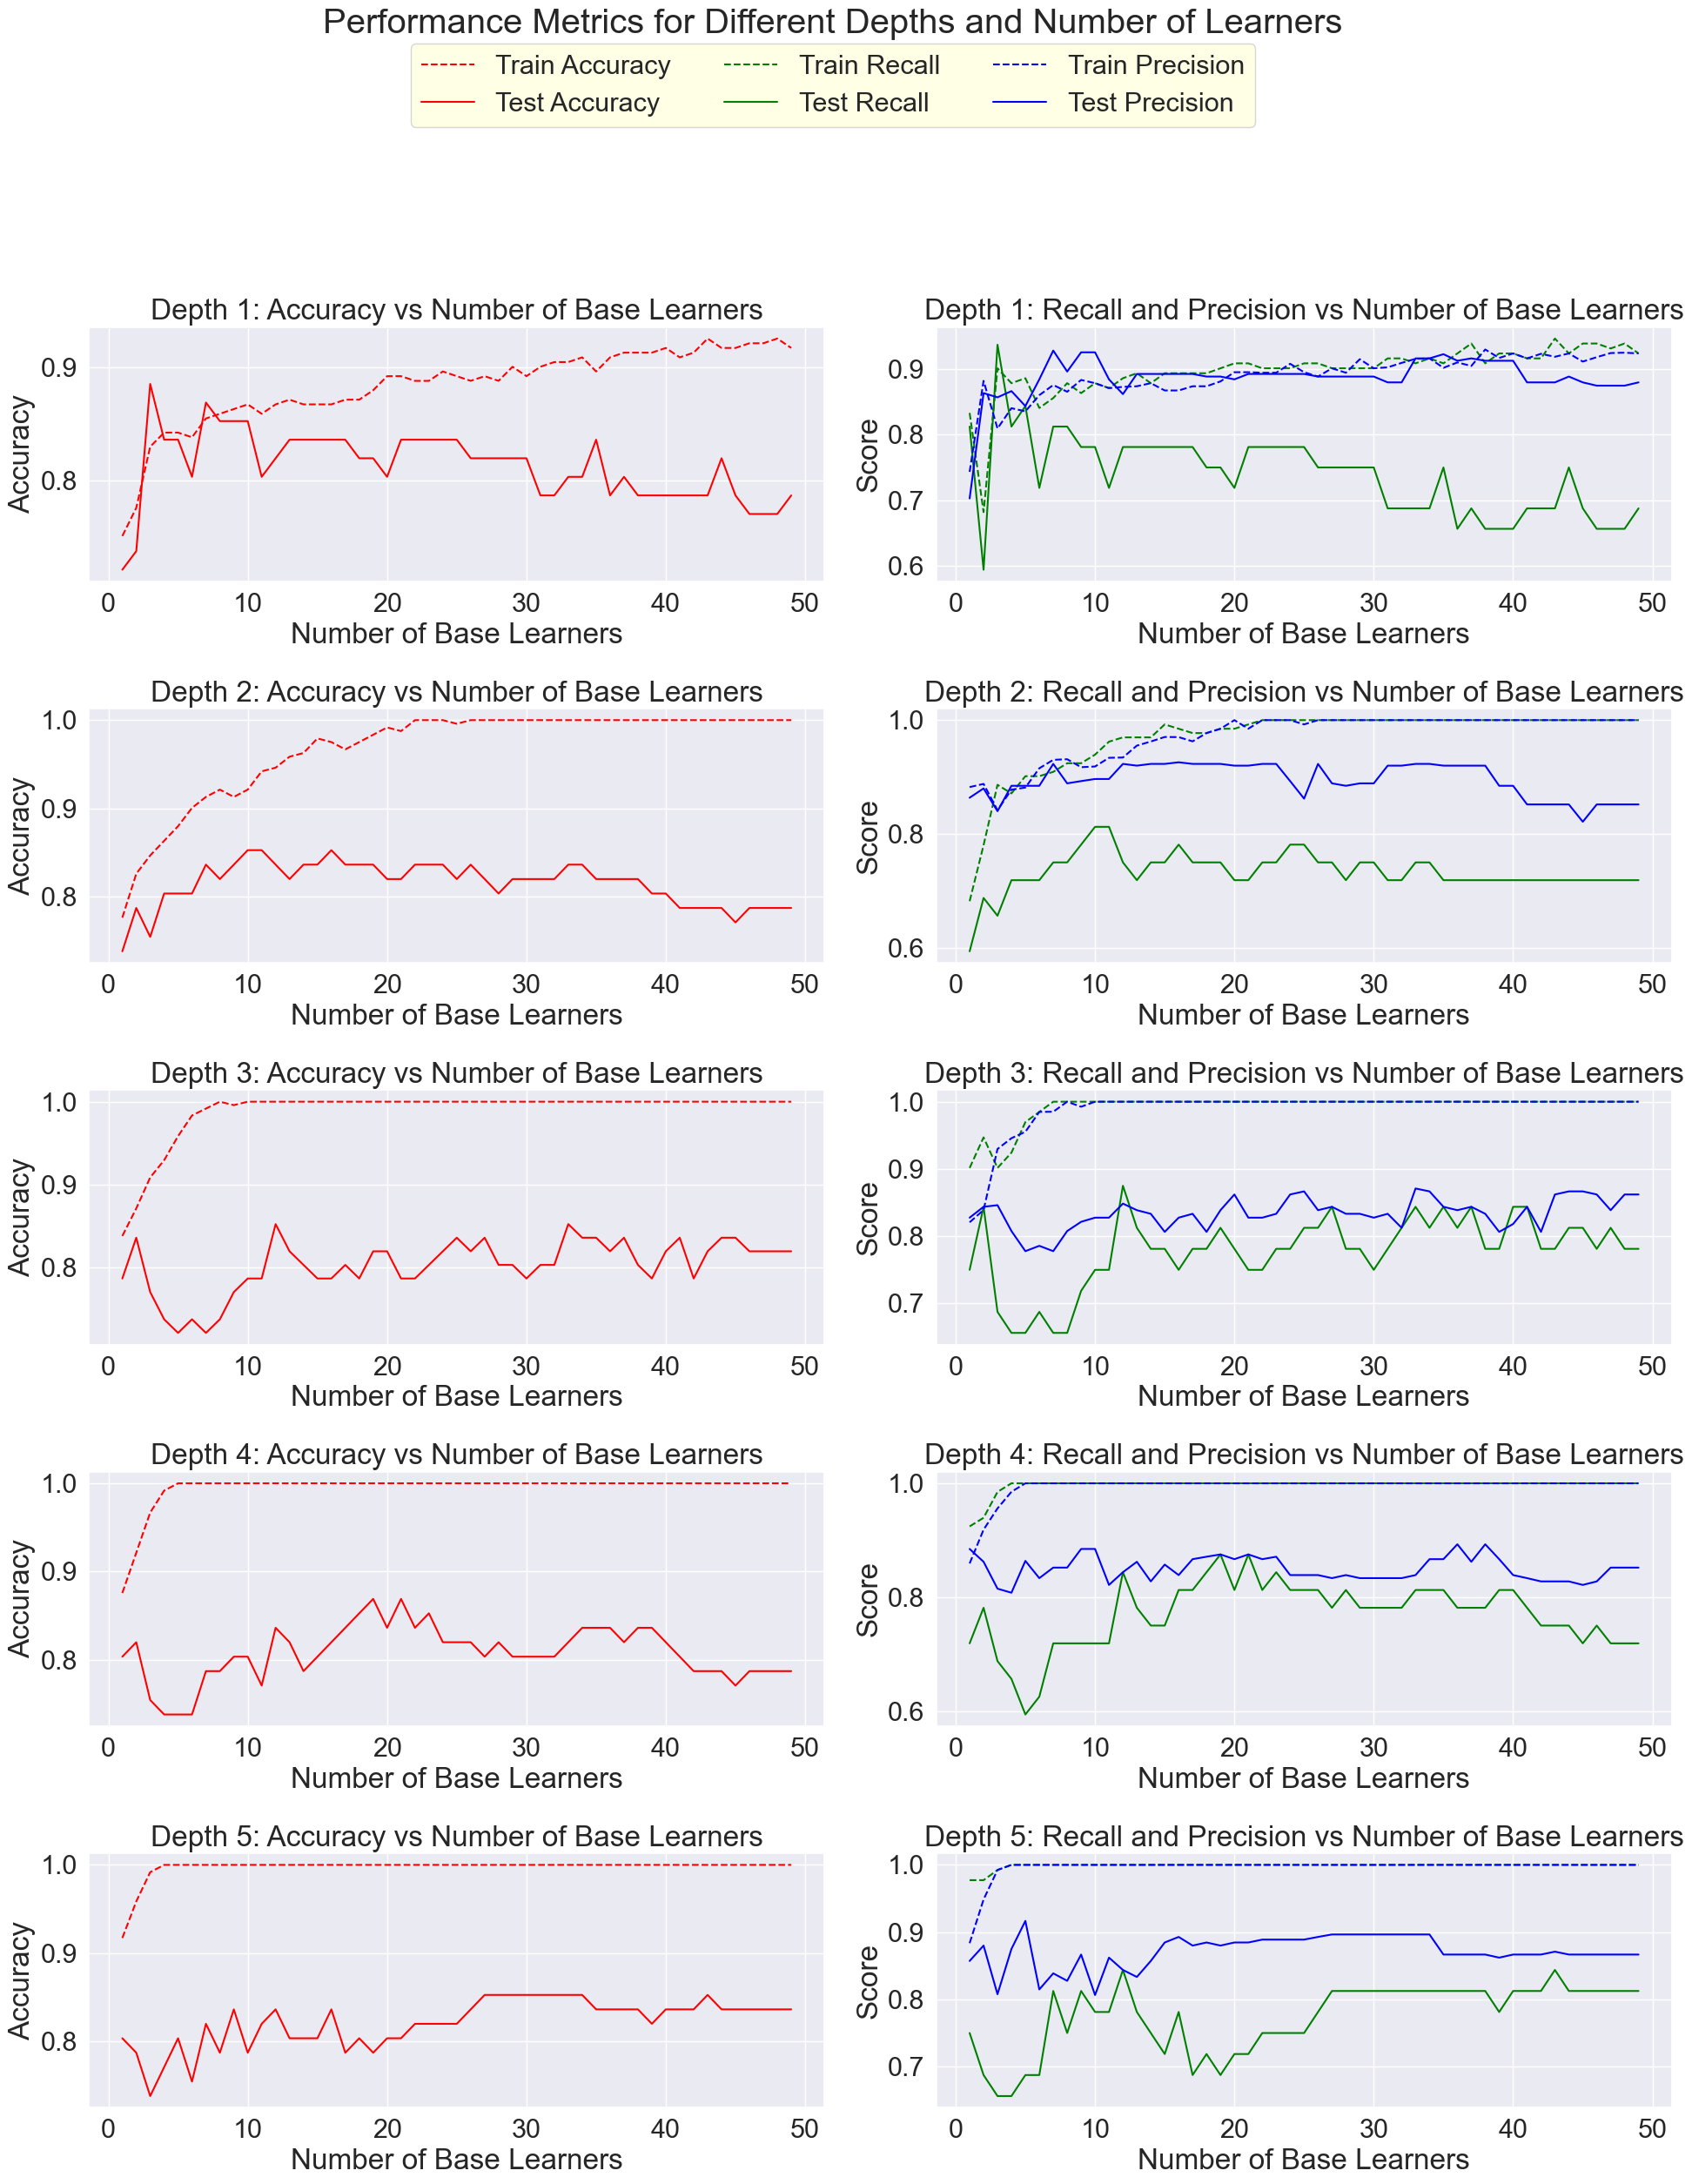

Best Depth: 1
Best Number of Learners: 3
Best Accuracy: 88.52%
Best Recall: 93.75%
Best Precision: 85.71%


In [30]:
# Create AdaBoost classifier with DecisionTree base learner
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)
# Lists to store metrics
best_depth = 0
best_learners = 0
best_accuracy = 0
best_recall = 0
best_precision = 0

# Lists to store metrics
depths = range(1, 6)  # Adjust the range of depths as needed

fig, axes = plt.subplots(nrows=len(depths), ncols=2, figsize=(20, 5 * len(depths)))
fig.suptitle('Performance Metrics for Different Depths and Number of Learners', y=1.01)

for i, depth in enumerate(depths):
    # Create lists to store metrics for the current depth
    train_accuracy = []
    test_accuracy = []
    train_recall = []
    test_recall = []
    train_precision = []
    test_precision = []

    # Set the depth of the decision tree
    clf.base_estimator.set_params(max_depth=depth)

    for num_learners in range(1, 50):
        # Set the number of base learners for the current iteration
        clf.n_estimators = num_learners

        # Train AdaBoost classifier
        clf.fit(X_train, y_train)

        # Predict on the training set
        train_predict = clf.predict(X_train)

        # Calculate metrics on the training set
        train_accuracy.append(accuracy_score(y_train, train_predict))
        train_recall.append(recall_score(y_train, train_predict))
        train_precision.append(precision_score(y_train, train_predict))

        # Predict on the test set
        test_predict = clf.predict(X_test)

        # Calculate metrics on the test set
        test_accuracy.append(accuracy_score(y_test, test_predict))
        test_recall.append(recall_score(y_test, test_predict))
        test_precision.append(precision_score(y_test, test_predict))
        
        # Update best metrics if the current model is better
        if accuracy_score(y_test, test_predict) > best_accuracy:
            best_depth = depth
            best_learners = num_learners
            best_accuracy = accuracy_score(y_test, test_predict)
            best_recall = recall_score(y_test, test_predict)
            best_precision = precision_score(y_test, test_predict)

    # Plot accuracy
    axes[i, 0].plot(range(1, 50), train_accuracy,color='red', linestyle='dashed')
    axes[i, 0].plot(range(1, 50), test_accuracy, color='red')
    axes[i, 0].set_xlabel('Number of Base Learners')
    axes[i, 0].set_ylabel('Accuracy')
    axes[i, 0].set_title(f'Depth {depth}: Accuracy vs Number of Base Learners')

    # Plot recall and precision
    axes[i, 1].plot(range(1, 50), train_recall,color='green',linestyle='dashed')
    axes[i, 1].plot(range(1, 50), test_recall,color='green')
    axes[i, 1].plot(range(1, 50), train_precision,color='blue', linestyle='dashed')
    axes[i, 1].plot(range(1, 50), test_precision,color='blue')
    axes[i, 1].set_xlabel('Number of Base Learners')
    axes[i, 1].set_ylabel('Score')
    axes[i, 1].set_title(f'Depth {depth}: Recall and Precision vs Number of Base Learners')

# display legend ouside of the charts to ensure readibility
fig.legend(["Train Accuracy", "Test Accuracy", "Train Recall", "Test Recall", "Train Precision", "Test Precision"],
           loc='upper center', bbox_to_anchor=(0.5,1.0), ncol=3, facecolor='lightyellow')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# Display the best results
print(f"Best Depth: {best_depth}")
print(f"Best Number of Learners: {best_learners}")
print(f"Best Accuracy: {best_accuracy:.2%}")
print(f"Best Recall: {best_recall:.2%}")
print(f"Best Precision: {best_precision:.2%}")

We see on the left hand side that the deeper the depth, the faster the Accuracy for trianing set is reaching 100%, so a depth of 5 only requires about 5 learners for trainig set to reach 100%.
But we also see that accuracy (at 88.52) for test is way lower on all charts, and actually the best accuracy is reached at a depth of 1 and with 3 learners. 

## Random Forest Classifier
Let's investigate this dataset with a random forest and see how good it performs.

In [31]:
# Create a list of n_estimators values to test (number of trees in the forest)
n_estimators_values = [2 ,5 , 10, 20, 30, 50, 100, 150, 200]

best_configuration = {'n_estimators': None, 'mean_cv_accuracy': 0.0}

for n_estimators in n_estimators_values:
    # Create a Random Forest Classifier
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

    # Calculate mean cross-validation accuracy
    mean_cv_accuracy = np.mean(cv_scores)

    # Check if the current configuration is the best
    if mean_cv_accuracy > best_configuration['mean_cv_accuracy']:
        best_configuration['n_estimators'] = n_estimators
        best_configuration['mean_cv_accuracy'] = mean_cv_accuracy

# Print results for the best configuration
print("---- Best Configuration ----- ")
print("n_estimators:", best_configuration['n_estimators'])
print("Mean CV Accuracy: %0.3f" % best_configuration['mean_cv_accuracy'])

# Fit the classifier on the training data with the best configuration
best_rf_model = RandomForestClassifier(n_estimators=best_configuration['n_estimators'], random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_rf_model.predict(X_test)

# Print model evaluation metrics for the best configuration
print("Model best Accuracy on Train:  %0.3f" % best_rf_model.score(X_train, y_train))
print("Model best Accuracy on Test: %0.3f" % best_rf_model.score(X_test, y_test))
print("Model Precision on Test:  %0.3f" % precision_score(y_test, y_pred_best))
print("Model Recall on Test: %0.3f" % recall_score(y_test, y_pred_best))


---- Best Configuration ----- 
n_estimators: 200
Mean CV Accuracy: 0.822
Model best Accuracy on Train:  1.000
Model best Accuracy on Test: 0.869
Model Precision on Test:  0.900
Model Recall on Test: 0.844


best RF accuracy is reaching 86.9, with 200 estimators

In [32]:
# Define the parameter grid
n_neighbors_values = [1,2,3,4,5,6,7,8,9,10,15,20,30]
param_grid = {'n_neighbors': n_neighbors_values}

# Create a K Neighbors Classifier
K_model = KNeighborsClassifier()

# Use GridSearchCV for cross-validated grid search
grid_search = GridSearchCV(K_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding mean cross-validated score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best mean cross-validated score:", best_score)

# Create the best K Neighbors Classifier with the best parameters
best_K_model = KNeighborsClassifier(**best_params)

# Fit the classifier on the training data
best_K_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_K_model.predict(X_test)

# Print model evaluation metrics for the best configuration
print("Model best Accuracy on Train: %0.3f" % best_K_model.score(X_train, y_train))
print("Model best Accuracy on Test: %0.3f" % best_K_model.score(X_test, y_test))
print("Model Precision on Test: %0.3f" % precision_score(y_test, y_pred_best))
print("Model Recall on Test: %0.3f" % recall_score(y_test, y_pred_best))


Best Parameters: {'n_neighbors': 4}
Best mean cross-validated score: 0.8216836734693878
Model best Accuracy on Train: 0.863
Model best Accuracy on Test: 0.803
Model Precision on Test: 0.917
Model Recall on Test: 0.688


KNN best accuracy of 80.3% is reached with 4 neighbors.
Cross validation adds almost 2pts, to 82.2% in accuracy to this model

### Support Vector Machine
We analyse this data set with an SVM testing several values for C and different Kernels

In [33]:
# Define the range of C values and kernels to test
param_grid = {'C': np.arange(0.1, 1.1, 0.1), 
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto', 0.1, 0.01, 0.001] 
             }

# Create SVM classifier
svm_classifier = svm.SVC(random_state=42)

# Use GridSearchCV for cross-validated grid search
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5)
grid_search.fit(X, y)

# Print the best parameters and corresponding mean cross-validated score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best mean cross-validated score: %0.2f" % best_score)

# Create an SVM classifier with the best parameters
best_svm_classifier = svm.SVC(**best_params, random_state=42)

# Fit the classifier on the training data
best_svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_svm_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Model Accuracy: %0.3f' % accuracy)
print('Model Precision: %0.2f' % precision)
print('Model Recall: %0.2f' % recall)


Best Parameters: {'C': 0.9, 'gamma': 'scale', 'kernel': 'poly'}
Best mean cross-validated score: 0.85
Model Accuracy: 0.869
Model Precision: 0.90
Model Recall: 0.84


Best accuracy of 86.9 is reached with c = 0.9 and a polynomial kernel, optimal gamma is scale, ie, 1/number of features

### ROC
For the sake of the exercise, I add below a ROC curve comparing the various models with the optimized parameters seen above

Optimizing parameters for Logistic Regression...
Optimizing parameters for Decision Tree...
Optimizing parameters for Optimized Decision Tree...
Optimizing parameters for AdaBoost...
Optimizing parameters for Random Forest...
Optimizing parameters for SVM...
                     Model  Accuracy    Recall  Precision
0      Logistic Regression  0.850765  0.878348   0.853716
3                 AdaBoost  0.846599  0.878917   0.849387
5                      SVM  0.846599  0.893732   0.836290
4            Random Forest  0.784354  0.825641   0.788501
1            Decision Tree  0.771854  0.832479   0.773347
2  Optimized Decision Tree  0.763265  0.832764   0.786362


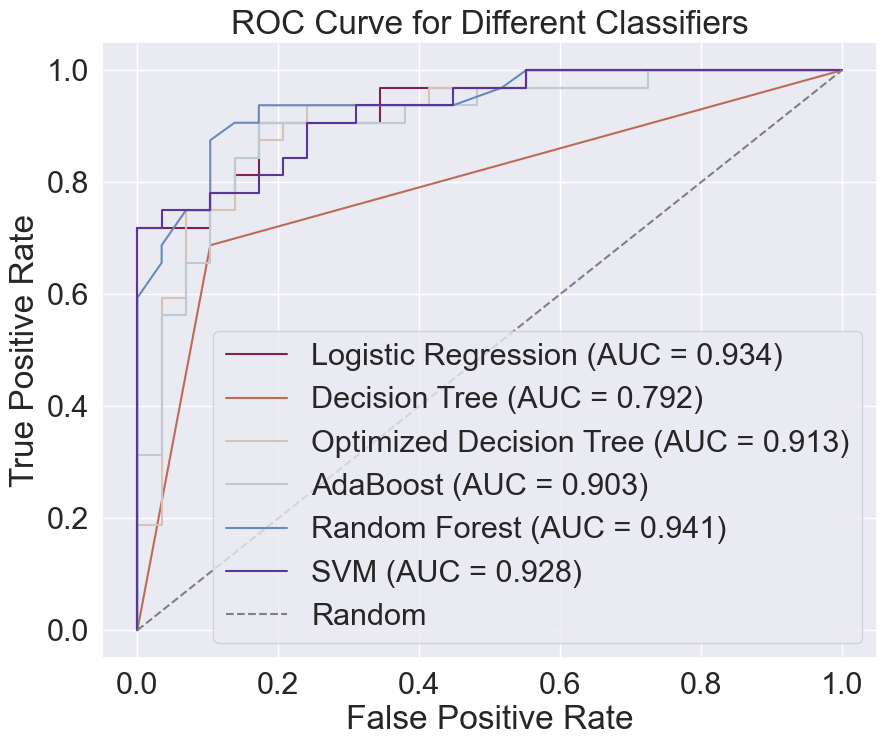

In [34]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Optimized Decision Tree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True)
}

# Define parameter grids for grid search
param_grids = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 0.5,1,1.5,2, 10, 100]},
    
    'Decision Tree': {'max_depth': [None,1,2,3, 4,5,6,7, 10, 15, 20]},
    
    'Optimized Decision Tree': {'max_depth': [None,1,2,3,4,5,6,7,8,9,10, 15, 20], 
                                'ccp_alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    
    'AdaBoost': {'n_estimators': [2,4,6,8,9,10,15,20,30], 
                'learning_rate': [0.01, 0.1,0.5, 1]},
                'max_depth': [None,1,2,3,4,5,6,7,8,9,10],
    
    'Random Forest': {'n_estimators': [10,20,30,40,50, 100, 150, 200], 
                      'max_depth': [None, 2,3,4,5,6,7,8,9, 10, 15, 20]},
    
    'SVM': {'C': [0.001, 0.01, 0.1, 0.9, 1, 1.1 , 5, 10, 100], 
            'gamma': ['scale','auto', 0.001, 0.01, 0.1, 1], 
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
           }
}

# Define scoring metric for grid search
scorer = make_scorer(roc_auc_score, greater_is_better=True)

# Dictionary to store results
results = {'Model': [], 'Accuracy': [], 'Recall': [], 'Precision': []}

# Loop over models
for model_name, model in models.items():
    print(f"Optimizing parameters for {model_name}...")

    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grids[model_name], scoring=scorer, cv=5)
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Evaluate the best model with cross-validation
    cv_accuracy = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    cv_recall = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall')
    cv_precision = cross_val_score(best_model, X_train, y_train, cv=5, scoring='precision')

    # Append results to the dictionary
    results['Model'].append(model_name)
    results['Accuracy'].append(np.mean(cv_accuracy))
    results['Recall'].append(np.mean(cv_recall))
    results['Precision'].append(np.mean(cv_precision))

#     print(f"{model_name} - Best parameters: {grid_search.best_params_}")
#     print(f"{model_name} - Cross-validated Accuracy: {np.mean(cv_accuracy):.3f}")
#     print(f"{model_name} - Cross-validated Recall: {np.mean(cv_recall):.3f}")
#     print(f"{model_name} - Cross-validated Precision: {np.mean(cv_precision):.3f}")
#     print("\n")

# Convert results dictionary to DataFrame
result_df = pd.DataFrame(results)

# Display the sorted table
result_df_sorted = result_df.sort_values(by='Accuracy', ascending=False)
print(result_df_sorted)

# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, clf in models.items():
    if name == 'Optimized Decision Tree':
        # Assuming grid_search is a dictionary containing the best model for each classifier
        best_model = grid_search.best_estimator_
        y_score = best_model.predict_proba(X_test)[:, 1]
    else:
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    auc_var = auc(fpr, tpr)  # Renamed variable to avoid conflict
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_var:.3f})')  # Use the renamed variable here

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Classifiers')
plt.legend(loc='lower right')
plt.show()

AUC and Accuracy appear to classify models in a different order.
When highest accuracy is for Logistic regression at 85% the highest AUC is for RF at 94.5, having its accuracy ranked in the 4th position at 82.2%) 

We know that class imbalance may impact accuracy and we have seen that in field: sex that is highly imbalanced, 
Below code tends to confirm this hypothesis as the 
 - Imbalance rate is significantly different from 100%, ie, the count of 0 vs 1 is significantly different
 - Imbalance percentage is significnatly different from 50%, ie, the weight of 0 in total sample
 both are the same measure viewed with a different angle so confirm each other, but helps understanding why accuracy might not be the best measure when ROC consider the model ability to discriminate between classes without being sensitive to parameters threshold and class imbalance.

In [35]:
# Function to calculate class imbalance metrics
def calculate_imbalance_metrics(y):
    class_counts = np.bincount(y)
    total_samples = len(y)
    
    # Calculate class imbalance ratio
    imbalance_ratio = class_counts[0] / class_counts[1]
    
    # Calculate class imbalance percentage
    imbalance_percentage = (class_counts[0] / total_samples) * 100
    
    return imbalance_ratio, imbalance_percentage

# Calculate imbalance metrics for training and testing sets
imbalance_ratio_train, imbalance_percentage_train = calculate_imbalance_metrics(X_train['sex'])
imbalance_ratio_test, imbalance_percentage_test = calculate_imbalance_metrics(X_test['sex'])

# Print results
print(f"Training Set - Imbalance Ratio: {imbalance_ratio_train:.2%}, Imbalance Percentage: {imbalance_percentage_train:.2f}%")
print(f"Testing Set  - Imbalance Ratio: {imbalance_ratio_test:.2%}, Imbalance Percentage: {imbalance_percentage_test:.2f}%")
#     print(f"{model_name} - Cross-validated Precision: {np.mean(cv_precision):.3f}")

Training Set - Imbalance Ratio: 53.50%, Imbalance Percentage: 34.85%
Testing Set  - Imbalance Ratio: 24.49%, Imbalance Percentage: 19.67%


## Conclusion

Random Forest is probably the best model to predict Heart Attack with this dataset,
should we modify the imbalance in some of the fields, we may consider another model.
Considering Logistic Regression is nonetheless valid as ranking high in both AUC and Accuracy